In [34]:
#Importación de Librerías
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from ast import literal_eval
from datetime import datetime
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
from sklearn.cluster import KMeans
import warnings
from sklearn.feature_extraction.text import CountVectorizer
import os
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)

In [35]:
data = pd.read_csv("/content/drive/MyDrive/Análisis de Usuarios del Metro/usuarios_rango_amplio_correcto.csv")

#Análisis de datos

In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225000 entries, 0 to 224999
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   HoraDeEntrada             225000 non-null  object
 1   HoraDeSalida              225000 non-null  object
 2   Fecha                     225000 non-null  object
 3   InteractuaConApp          225000 non-null  object
 4   ComprasEnApp              225000 non-null  int64 
 5   Ruta                      225000 non-null  object
 6   Estación de entrada       225000 non-null  object
 7   Estación de salida        225000 non-null  object
 8   Lineas que fueron usadas  225000 non-null  object
 9   ID_USUARIO                225000 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 17.2+ MB
None


In [5]:
print(data.describe())

print(data.describe(include='object'))

        ComprasEnApp     ID_USUARIO
count  225000.000000  225000.000000
mean        6.496658    7500.500000
std         4.031533    4330.136632
min         0.000000       1.000000
25%         3.000000    3750.750000
50%         6.000000    7500.500000
75%        10.000000   11250.250000
max        13.000000   15000.000000
       HoraDeEntrada HoraDeSalida       Fecha InteractuaConApp  \
count         225000       225000      225000           225000   
unique           420          810          15                2   
top         09:32:00     09:14:00  03/07/2023               No   
freq             631          601       15000           113023   

                                                     Ruta Estación de entrada  \
count                                              225000              225000   
unique                                              11439                 163   
top     ['LOS REYES', 'SANTA MARTA', 'ACATITLA', 'PEÑÓ...             VIVEROS   
freq                 

In [6]:
# Identificar valores faltantes en cada columna
print(data.isnull().sum())

HoraDeEntrada               0
HoraDeSalida                0
Fecha                       0
InteractuaConApp            0
ComprasEnApp                0
Ruta                        0
Estación de entrada         0
Estación de salida          0
Lineas que fueron usadas    0
ID_USUARIO                  0
dtype: int64


In [7]:
data.head(6)

,HoraDeEntrada,HoraDeSalida,Fecha,InteractuaConApp,ComprasEnApp,Ruta,Estación de entrada,Estación de salida,Lineas que fueron usadas,ID_USUARIO
0,06:39:00,07:59:00,03/07/2023,Si,1,"['JUANACATLÁN', 'CHAPULTEPEC', 'SEVILLA', 'INS...",JUANACATLÁN,SAN LÁZARO,"[1, 3, 11]",1
1,06:34:00,08:24:00,04/07/2023,No,4,"['JUANACATLÁN', 'CHAPULTEPEC', 'SEVILLA', 'INS...",JUANACATLÁN,SAN LÁZARO,"[1, 3, 11]",1
2,06:01:00,07:11:00,05/07/2023,No,7,"['JUANACATLÁN', 'CHAPULTEPEC', 'SEVILLA', 'INS...",JUANACATLÁN,SAN LÁZARO,"[1, 3, 11]",1
3,06:50:00,07:40:00,06/07/2023,Si,6,"['JUANACATLÁN', 'CHAPULTEPEC', 'SEVILLA', 'INS...",JUANACATLÁN,SAN LÁZARO,"[1, 3, 11]",1
4,06:55:00,08:25:00,07/07/2023,No,0,"['JUANACATLÁN', 'CHAPULTEPEC', 'SEVILLA', 'INS...",JUANACATLÁN,SAN LÁZARO,"[1, 3, 11]",1
5,06:56:00,08:46:00,08/07/2023,Si,8,"['JUANACATLÁN', 'CHAPULTEPEC', 'SEVILLA', 'INS...",JUANACATLÁN,SAN LÁZARO,"[1, 3, 11]",1


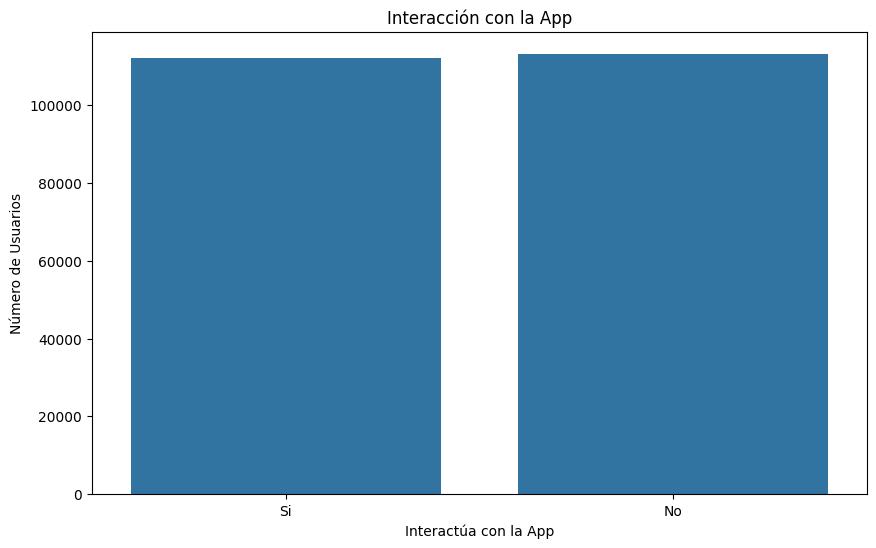

In [8]:
# Conteo de valores para visualizar cuántos usuarios interactúan con la app
plt.figure(figsize=(10, 6))
sns.countplot(x='InteractuaConApp', data=data)
plt.title('Interacción con la App')
plt.xlabel('Interactúa con la App')
plt.ylabel('Número de Usuarios')
plt.show()

  Si hay uniformidad es por cómo se simularon los datos, se randomizaron los datos e un rango estipulado.

##Tops

###Usuarios con más compras durante 15 días

In [9]:
compras_por_usuario = data.groupby('ID_USUARIO')['ComprasEnApp'].sum()

usuarios_con_mayores_compras = compras_por_usuario.sort_values(ascending=False)

print(usuarios_con_mayores_compras.head(5))

ID_USUARIO
6360    153
412     153
6258    152
3873    151
2513    150
Name: ComprasEnApp, dtype: int64


In [10]:
# Dándole el formato correcto de las horas
data['HoraDeEntrada'] = pd.to_datetime(data['HoraDeEntrada'], format='%H:%M:%S').dt.time

compras_por_usuario = data.groupby('ID_USUARIO')['ComprasEnApp'].sum()

# Ordenando los usuarios por el número total de compras de mayor a menor y obtener los 5 primeros
top_compradores = compras_por_usuario.sort_values(ascending=False).head(5).index

# Filtrando los datos para obtener solo los viajes de los 5 principales usuarios
viajes_top_compradores = data[data['ID_USUARIO'].isin(top_compradores)]

# Asumiendo que el viaje al trabajo es por la mañana, filtrar por horario de mañana, antes de las 10 a.m.
viajes_trabajo = viajes_top_compradores[viajes_top_compradores['HoraDeEntrada'] < pd.to_datetime('10:00:00').time()]

# Encontrar la estación de salida más común por la mañana para cada uno de los 5 principales usuarios
estacion_trabajo_comun = viajes_trabajo.groupby('ID_USUARIO')['Estación de salida'].agg(lambda x: x.value_counts().index[0])

# Crear recomendaciones para un viaje gratis
recomendaciones = estacion_trabajo_comun.apply(lambda estacion: f"Ofrecer un viaje gratis a la estación {estacion} como incentivo")

print(recomendaciones)

ID_USUARIO
412     Ofrecer un viaje gratis a la estación GUELATAO...
2513    Ofrecer un viaje gratis a la estación BOULEVAR...
3873    Ofrecer un viaje gratis a la estación LOMAS ES...
6258    Ofrecer un viaje gratis a la estación BALBUENA...
6360    Ofrecer un viaje gratis a la estación LINDAVIS...
Name: Estación de salida, dtype: object


###Horarios de mayor afluencia

In [59]:
data['Hora'] = pd.to_datetime(data['HoraDeEntrada'], format='%H:%M:%S', errors='coerce').dt.hour

afluencia_por_hora = data.groupby('Hora').size()

horarios_mayor_afluencia = afluencia_por_hora.sort_values(ascending=False)

print(horarios_mayor_afluencia)

Hora
9     33870
7     33450
8     32055
10    31830
6     31365
11    31350
5     31080
dtype: int64


In [60]:
conteo_por_hora = data.groupby('HoraDeEntrada').size()

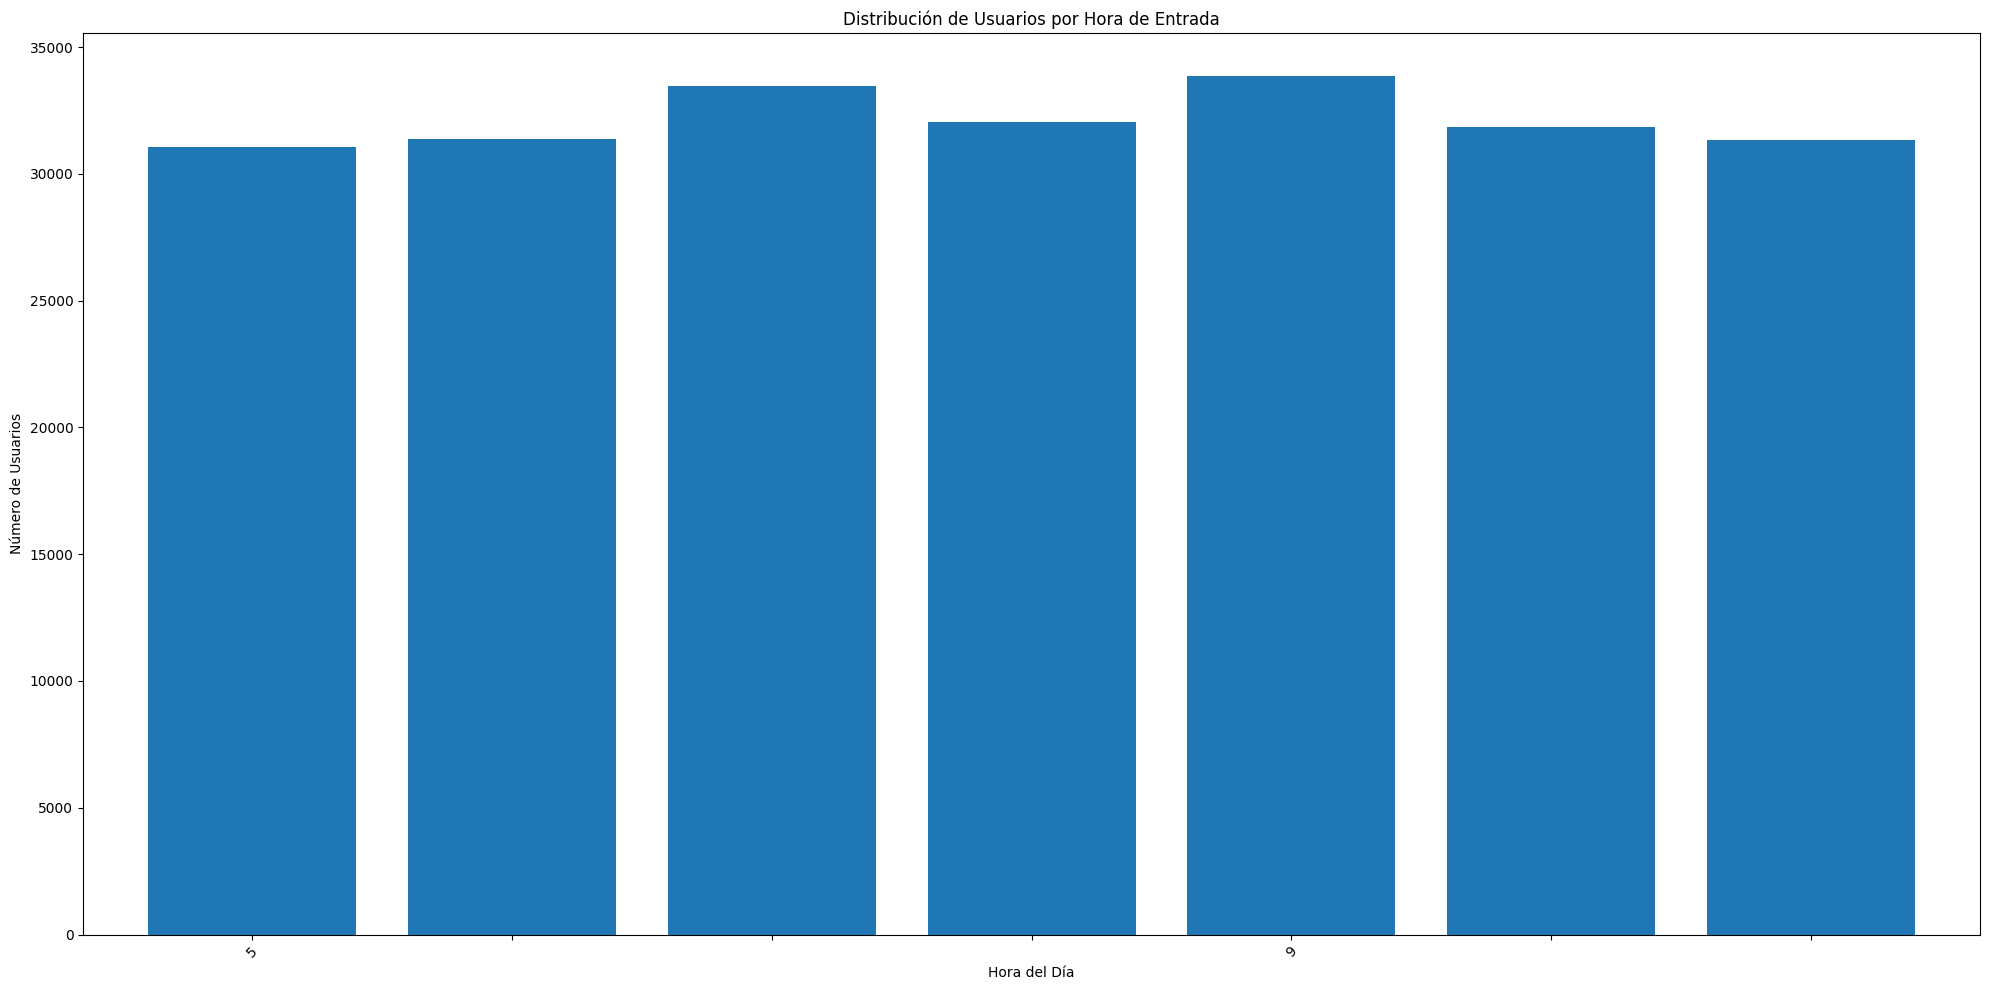

In [61]:
plt.figure(figsize=(20, 10))
afluencia_por_hora.plot(kind='bar', width=0.8)

plt.xticks(rotation=45)
plt.xlabel('Hora del Día')
plt.ylabel('Número de Usuarios')
plt.title('Distribución de Usuarios por Hora de Entrada')


tick_positions = np.arange(0, len(afluencia_por_hora), step=1)
tick_labels = [label if i%4 == 0 else "" for i, label in enumerate(afluencia_por_hora.index)]
plt.xticks(ticks=tick_positions, labels=tick_labels)


plt.tight_layout()
plt.show()

In [62]:
data['HoraSalida'] = pd.to_datetime(data['HoraDeSalida'], format='%H:%M:%S').dt.hour


distribucion_salidas = data.groupby('HoraSalida').size()


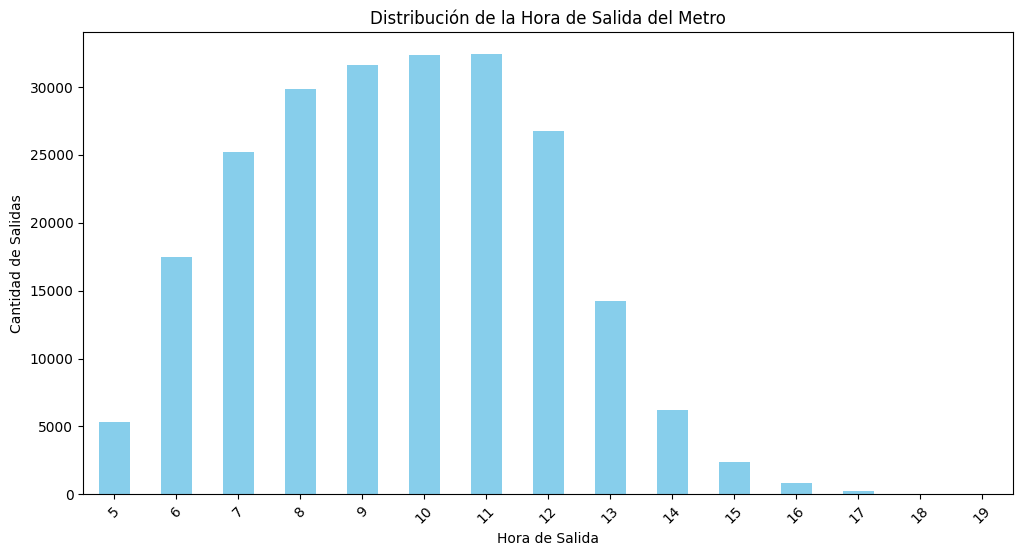

In [63]:
# Gráfico de barras para visualizar la distribución de salidas por hora
plt.figure(figsize=(12, 6))
distribucion_salidas.plot(kind='bar', color='skyblue')
plt.title('Distribución de la Hora de Salida del Metro')
plt.xlabel('Hora de Salida')
plt.ylabel('Cantidad de Salidas')
plt.xticks(rotation=45)
plt.show()

###Rutas con mayor afluencia

In [65]:
frecuencia_rutas = data['Ruta'].value_counts()

rutas_mayor_afluencia = frecuencia_rutas.head()

print(rutas_mayor_afluencia)

['LOS REYES', 'SANTA MARTA', 'ACATITLA', 'PEÑÓN VIEJO', 'GUELATAO', 'TEPALCATES', 'CANAL DE SAN JUAN', 'AGRÍCOLA ORIENTAL', 'PANTITLÁN', 'HANGARES', 'TERMINAL AÉREA', 'OCEANÍA', 'DEPORTIVO OCEANÍA', 'BOSQUES DE ARAGÓN', 'VILLA DE ARAGÓN', 'NEZAHUALCÓYOTL', 'IMPULSORA', 'RÍO DE LOS REMEDIOS', 'MUZQUIZ', 'ECATEPEC']    90
['PEÑÓN VIEJO', 'GUELATAO', 'TEPALCATES', 'CANAL DE SAN JUAN', 'AGRÍCOLA ORIENTAL', 'PANTITLÁN', 'PUEBLA', 'CIUDAD DEPORTIVA', 'VELODROMO', 'MIXIUHCA', 'JAMAICA', 'CHABACANO', 'SAN ANTONIO ABAD', 'PINO SUÁREZ']                                                                                                             75
['INSURGENTES', 'CUAUHTÉMOC', 'BALDERAS', 'JUÁREZ', 'HIDALGO', 'GUERRERO', 'TEPITO', 'MORELOS', 'CANAL DEL NORTE', 'CONSULADO', 'BONDOJITO', 'TALISMÁN']                                                                                                                                                                       75
['CHAPULTEPEC', 'JUANACATLÁN', 'TA

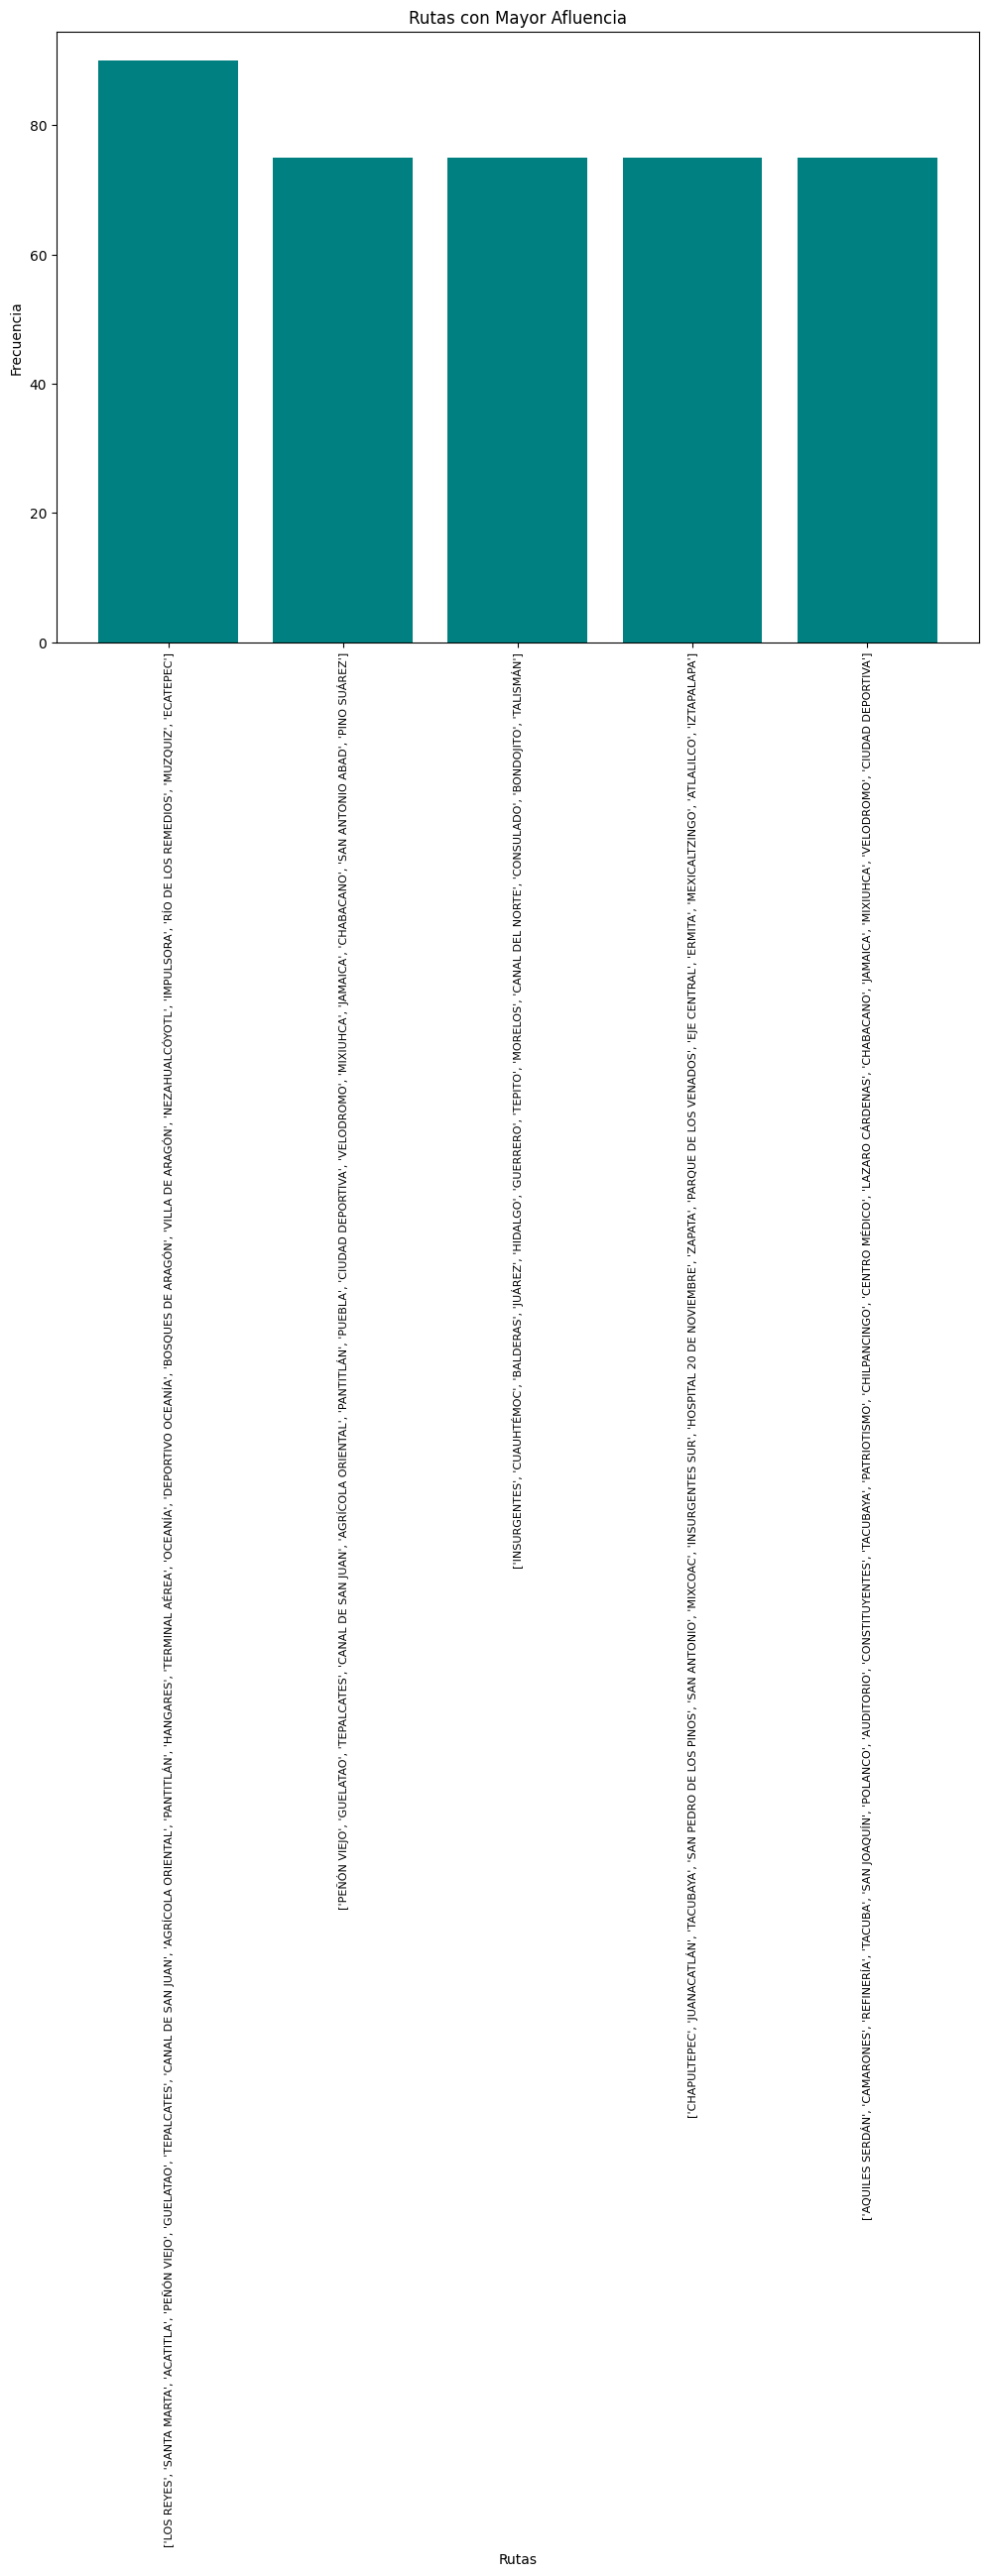

In [17]:
rutas = rutas_mayor_afluencia.index
frecuencias = rutas_mayor_afluencia.values

plt.figure(figsize=(12, 8))
plt.bar(rutas, frecuencias, color='teal')
plt.xlabel('Rutas')
plt.ylabel('Frecuencia')
plt.title('Rutas con Mayor Afluencia')
plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()
plt.show()

###Estaciones de entrada con mayor afluencia por horario de acuerdo a cada usuario

In [57]:
conteo_estaciones = data.groupby('Estación de entrada').size()

top_10_estaciones = conteo_estaciones.sort_values(ascending=False).head(10)

print(top_10_estaciones)

Estación de entrada
VIVEROS               1905
ISABEL LA CATÓLICA    1755
VELODROMO             1740
ECATEPEC              1725
ACULCO                1725
CONSULADO             1695
DEPORTIVO OCEANÍA     1665
LA VIGA               1665
POLANCO               1650
MERCED                1635
dtype: int64


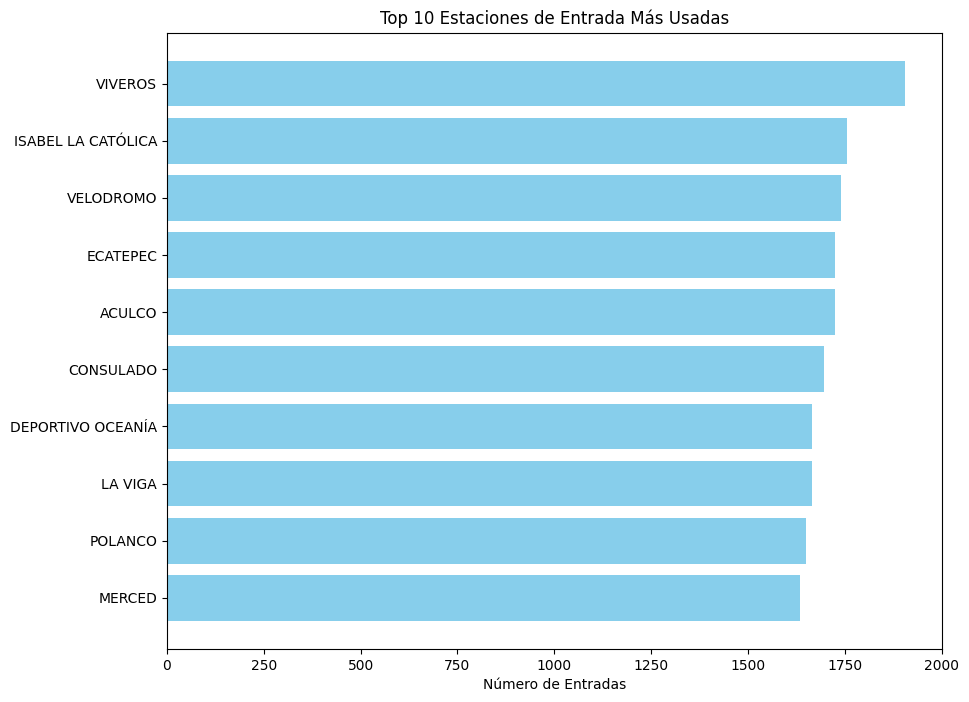

In [56]:
estaciones = top_10_estaciones.index
conteos = top_10_estaciones.values

plt.figure(figsize=(10, 8))
plt.barh(estaciones, conteos, color='skyblue')
plt.xlabel('Número de Entradas')
plt.title('Top 10 Estaciones de Entrada Más Usadas')
plt.gca().invert_yaxis()
plt.show()

In [55]:

afluencia_por_hora_estacion = data.groupby(['HoraDeEntrada', 'Estación de entrada']).size()
afluencia_df = afluencia_por_hora_estacion.reset_index(name='Conteo')
afluencia_df.sort_values(by=['HoraDeEntrada', 'Conteo'], ascending=[True, False], inplace=True)
estaciones_entrada_mayor_afluencia_por_hora = afluencia_df.groupby('HoraDeEntrada').head(20)

print(estaciones_entrada_mayor_afluencia_por_hora)

      HoraDeEntrada Estación de entrada  Conteo
31         05:00:00            COYOACÁN      12
18         05:00:00   CANAL DE SAN JUAN       8
93         05:00:00        OBSERVATORIO       8
3          05:00:00            APATLACO       7
4          05:00:00      AQUILES SERDÁN       7
...             ...                 ...     ...
64591      11:59:00              ACULCO       5
64596      11:59:00              ARAGÓN       5
64628      11:59:00          CUAUHTÉMOC       5
64644      11:59:00       FRAY SERVANDO       5
64648      11:59:00            GUERRERO       5

[8400 rows x 3 columns]


In [54]:
# Agrupando por ID de usuario, 'HoraDeEntrada' y 'Estación de entrada', y contar el número de entradas
afluencia_por_usuario_hora_estacion = data.groupby(['ID_USUARIO', 'HoraDeEntrada', 'Estación de entrada']).size().reset_index(name='Conteo')

# Ordenando los datos para obtener las estaciones con mayor afluencia por cada combinación de usuario y hora
afluencia_por_usuario_hora_estacion.sort_values(by=['ID_USUARIO', 'HoraDeEntrada', 'Conteo'], ascending=[True, True, False], inplace=True)

# Para cada combinación de usuario y hora, seleccionar la estación de entrada con mayor afluencia
estaciones_mayor_afluencia_por_usuario_hora = afluencia_por_usuario_hora_estacion.groupby(['ID_USUARIO', 'HoraDeEntrada']).first().reset_index()

print(estaciones_mayor_afluencia_por_usuario_hora.head())

   ID_USUARIO HoraDeEntrada Estación de entrada  Conteo
0           1      06:00:00         JUANACATLÁN       1
1           1      06:01:00         JUANACATLÁN       1
2           1      06:07:00         JUANACATLÁN       1
3           1      06:11:00         JUANACATLÁN       1
4           1      06:32:00         JUANACATLÁN       2


In [53]:
data['Fecha'] = pd.to_datetime(data['Fecha'], format='%d/%m/%Y')

afluencia_por_usuario_fecha_hora_estacion = data.groupby(['ID_USUARIO', 'Fecha', 'HoraDeEntrada', 'Estación de entrada']).size().reset_index(name='Conteo')

afluencia_por_usuario_fecha_hora_estacion.sort_values(by=['ID_USUARIO', 'Fecha', 'HoraDeEntrada', 'Conteo'], ascending=[True, True, True, False], inplace=True)

estaciones_mayor_afluencia_por_usuario_fecha_hora = afluencia_por_usuario_fecha_hora_estacion.groupby(['ID_USUARIO', 'Fecha', 'HoraDeEntrada']).first().reset_index()

print(estaciones_mayor_afluencia_por_usuario_fecha_hora.head(5))

   ID_USUARIO      Fecha HoraDeEntrada Estación de entrada  Conteo
0           1 2023-07-03      06:39:00         JUANACATLÁN       1
1           1 2023-07-04      06:34:00         JUANACATLÁN       1
2           1 2023-07-05      06:01:00         JUANACATLÁN       1
3           1 2023-07-06      06:50:00         JUANACATLÁN       1
4           1 2023-07-07      06:55:00         JUANACATLÁN       1


In [49]:
# Agrupando por Fecha, HoraDeEntrada y Estación de entrada, y contar el número de entradas
entradas_por_fecha_hora_estacion = data.groupby(['Fecha', 'HoraDeEntrada', 'Estación de entrada']).size().reset_index(name='Conteo')

entradas_por_fecha_hora_estacion.sort_values(by=['Fecha', 'HoraDeEntrada', 'Conteo'], ascending=[True, True, False], inplace=True)

top_entradas_por_fecha_hora = entradas_por_fecha_hora_estacion.groupby(['Fecha', 'HoraDeEntrada']).head(20)

print(top_entradas_por_fecha_hora)

             Fecha HoraDeEntrada     Estación de entrada  Conteo
7       03/07/2023      05:00:00                GUERRERO       2
9       03/07/2023      05:00:00         INSURGENTES SUR       2
20      03/07/2023      05:00:00                  OLIVOS       2
22      03/07/2023      05:00:00              SAN LÁZARO       2
0       03/07/2023      05:00:00               AUDITORIO       1
...            ...           ...                     ...     ...
202046  19/07/2023      11:59:00        HOSPITAL GENERAL       1
202048  19/07/2023      11:59:00  INSTITUTO DEL PETRÓLEO       1
202049  19/07/2023      11:59:00               NATIVITAS       1
202050  19/07/2023      11:59:00                  OBRERA       1
202051  19/07/2023      11:59:00             PATRIOTISMO       1

[125936 rows x 4 columns]


###Estaciones de salida con mayor afluencia

In [47]:
conteo_salidas_por_estacion = data.groupby('Estación de salida').size()

top_estaciones_salida = conteo_salidas_por_estacion.sort_values(ascending=False).head(10)

print(top_estaciones_salida)

Estación de salida
RÍO DE LOS REMEDIOS      1695
BELLAS ARTES             1695
TEZOZOMOC                1665
BONDOJITO                1650
DEPORTIVO 18 DE MARZO    1635
TLÁHUAC                  1635
EJE CENTRAL              1620
HIDALGO                  1620
OLÍMPICA                 1605
SAN JOAQUÍN              1605
dtype: int64


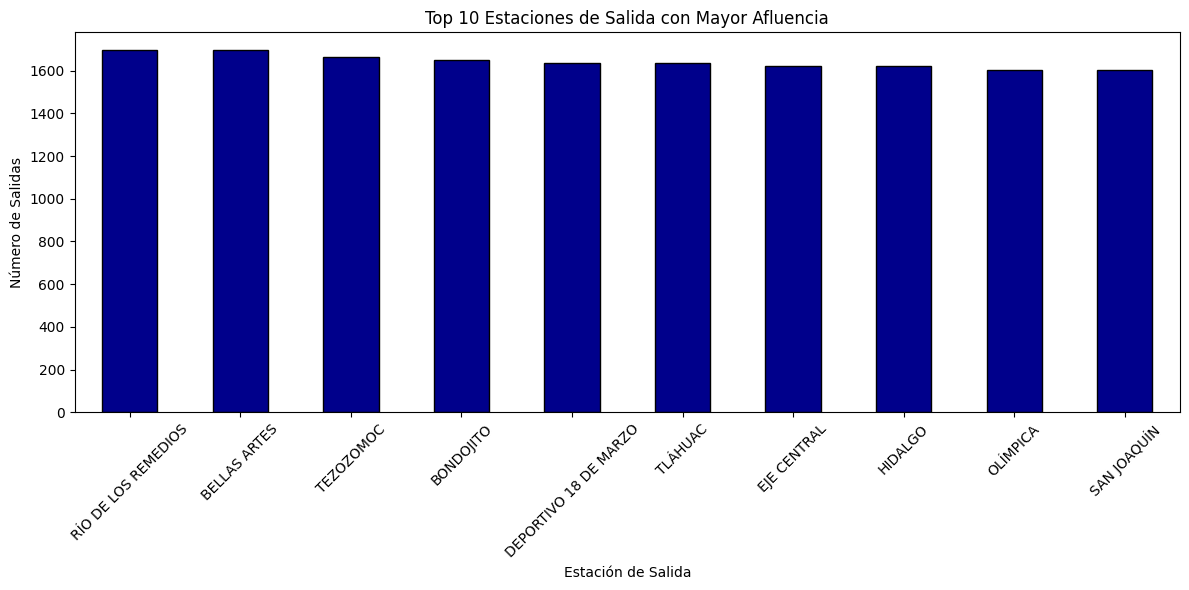

In [45]:
# Creando un gráfico de barras para visualizar las 10 estaciones de salida con mayor afluencia
plt.figure(figsize=(12, 6))
top_estaciones_salida.plot(kind='bar', color='darkblue', edgecolor='black')
plt.title('Top 10 Estaciones de Salida con Mayor Afluencia')
plt.xlabel('Estación de Salida')
plt.ylabel('Número de Salidas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###Usuarios únicos VS Usuarios con viajes repetidos:

In [43]:
# Contar el número total de viajes
total_viajes = len(data)

# Contar el número de viajes únicos por usuario
viajes_por_usuario = data.groupby('ID_USUARIO').size()

# Determinar usuarios únicos (usuarios que tienen solo un viaje)
usuarios_unicos = viajes_por_usuario[viajes_por_usuario == 1].count()

# Determinar usuarios con viajes repetidos (usuarios que tienen más de un viaje)
usuarios_repetidos = viajes_por_usuario[viajes_por_usuario > 1].count()

# Proporciones
proporcion_usuarios_unicos = usuarios_unicos / total_viajes
proporcion_usuarios_repetidos = usuarios_repetidos / total_viajes

print("Proporción de usuarios únicos:", proporcion_usuarios_unicos)
print("Proporción de usuarios con viajes repetidos:", proporcion_usuarios_repetidos)

Proporción de usuarios únicos: 0.0
Proporción de usuarios con viajes repetidos: 0.06666666666666667


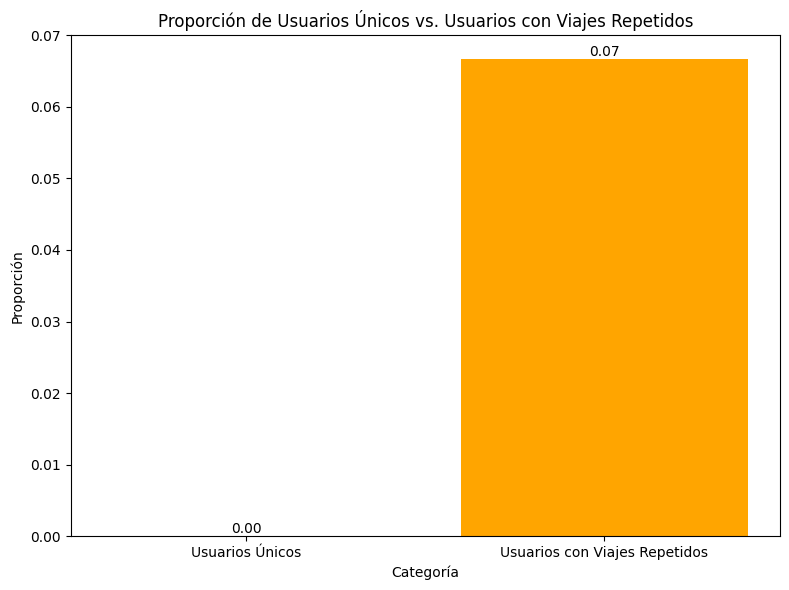

In [41]:
categorias = ['Usuarios Únicos', 'Usuarios con Viajes Repetidos']
valores = [proporcion_usuarios_unicos, proporcion_usuarios_repetidos]

# Crear un gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(categorias, valores, color=['blue', 'orange'])

plt.title('Proporción de Usuarios Únicos vs. Usuarios con Viajes Repetidos')
plt.xlabel('Categoría')
plt.ylabel('Proporción')

# Mostrar valores en las barras
for i in range(len(valores)):
    plt.text(i, valores[i], f'{valores[i]:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

###Correlacion entre variables

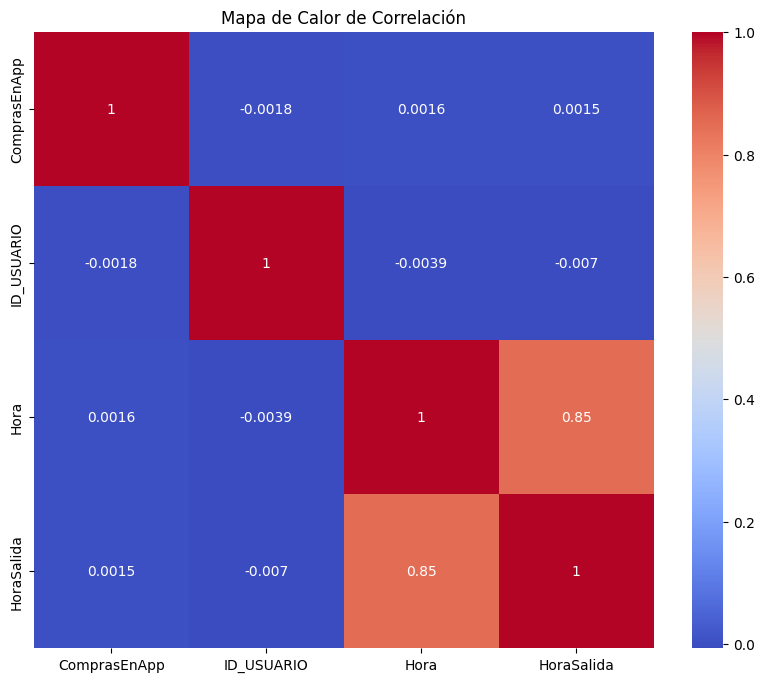

In [28]:
correlacion = data.corr()

# Visualizando la matriz de correlación con un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', cbar=True)
plt.title('Mapa de Calor de Correlación')
plt.show()

#Clusters

###MINUTOS DE SALIDA Y ENTRADA POR USUARIO

In [36]:
#Casting (conviertiendo los horaios a minutos para la clusterización)
def hora_a_minutos(hora):

    if isinstance(hora, str):
        try:
            h, m, s = map(int, hora.split(':'))
            return h * 60 + m
        except ValueError:
            return 0
    else:
        return 0

data['MinutosEntrada'] = data['HoraDeEntrada'].apply(hora_a_minutos)
data['MinutosSalida'] = data['HoraDeSalida'].apply(hora_a_minutos)

In [37]:
X = data[['MinutosEntrada', 'MinutosSalida']].to_numpy()

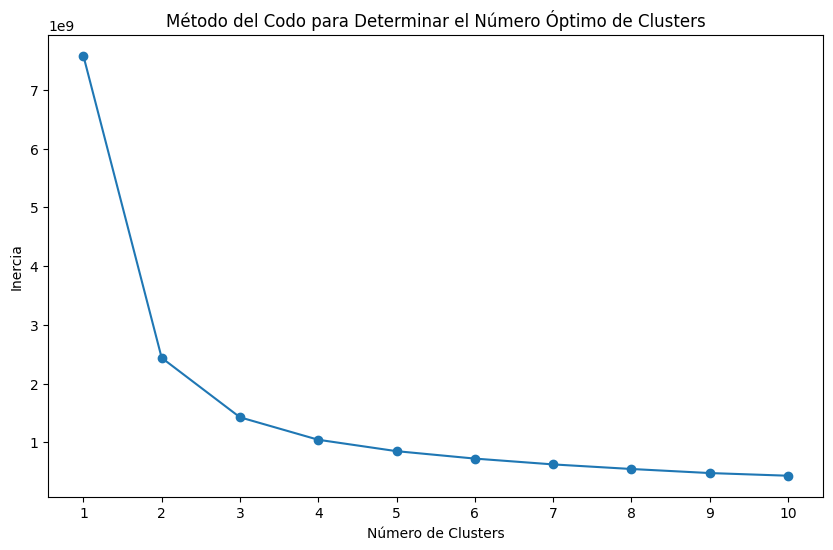

In [38]:
# Calculando la inercia para un rango óptimo de clusters
inercias = []
rangos_clusters = range(1, 11)

for k in rangos_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inercias.append(kmeans.inertia_)

# Graficar la inercia para ver el "codo"
plt.figure(figsize=(10, 6))
plt.plot(rangos_clusters, inercias, '-o')
plt.title('Método del Codo para Determinar el Número Óptimo de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.xticks(rangos_clusters)
plt.show()

In [39]:
# K-Means con 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

# Agregar los clusters al dataframe
data['Cluster_Horas'] = clusters

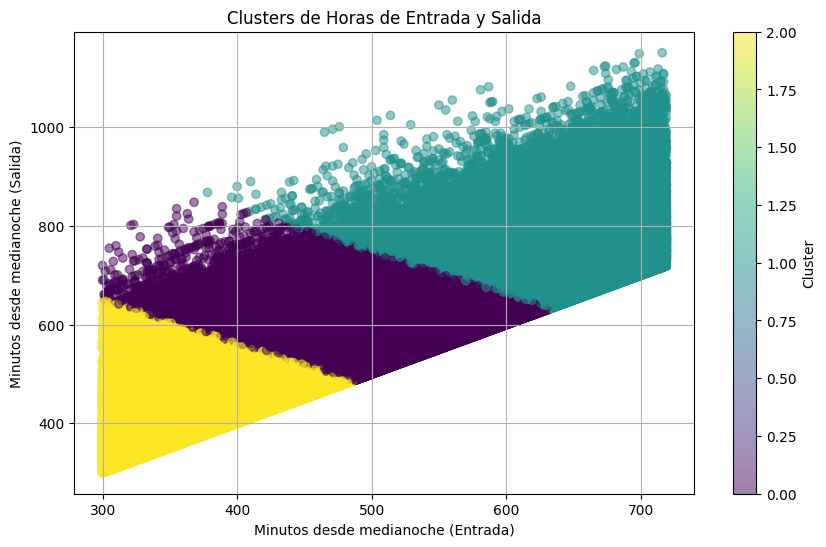

In [67]:
plt.figure(figsize=(10, 6))
plt.scatter(data['MinutosEntrada'], data['MinutosSalida'], c=data['Cluster_Horas'], cmap='viridis', alpha=0.5)
plt.title('Clusters de Horas de Entrada y Salida')
plt.xlabel('Minutos desde medianoche (Entrada)')
plt.ylabel('Minutos desde medianoche (Salida)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [77]:
# Función para convertir minutos desde medianoche a formato HH:MM:SS
def minutos_a_hms(minutos):
    horas = int(minutos // 60)
    minutos = int(minutos % 60)
    return f"{horas:02d}:{minutos:02d}:00"

# Agrupando los datos por cluster y obtener las estadísticas descriptivas
estadisticas_clusters = data.groupby('Cluster_Horas').agg({
    'MinutosEntrada': ['mean', 'median', 'std', 'min', 'max', lambda x: stats.mode(x)[0]],
    'MinutosSalida': ['mean', 'median', 'std', 'min', 'max', lambda x: stats.mode(x)[0]]
})

# Convirtiendo las estadísticas a formato de horas, minutos y segundos
estadisticas_clusters_formato_hms = estadisticas_clusters.copy()
for col in estadisticas_clusters.columns.levels[0]:
    estadisticas_clusters_formato_hms[col] = estadisticas_clusters[col].applymap(minutos_a_hms)

estadisticas_clusters_formato_hms

MinutosEntrada                                          \
                        mean    median       std       min       max   
Cluster_Horas                                                          
0                   08:29:00  08:31:00  00:55:00  05:00:00  10:32:00   
1                   10:44:00  10:50:00  00:49:00  06:18:00  11:59:00   
2                   06:13:00  06:10:00  00:45:00  05:00:00  08:06:00   

                         MinutosSalida                                \
              <lambda_0>          mean    median       std       min   
Cluster_Horas                                                          
0               08:21:00      10:04:00  10:03:00  00:53:00  08:07:00   
1               10:51:00      12:39:00  12:27:00  01:11:00  10:33:00   
2               05:04:00      07:29:00  07:32:00  00:59:00  05:00:00   

                                    
                    max <lambda_0>  
Cluster_Horas                       
0              14:08:00   10:27:00  
1              19:11:00   12:17:00  
2              10:48:00   07:51:00

###RUTAS POR USUARIO

In [34]:
#Convirtiendo las rutas a una cadena de texto por cada usuario
data['Ruta'] = data['Ruta'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
data['Ruta_str'] = data['Ruta'].apply(lambda x: ' '.join(x))

Usaremos CountVectorizer para convertir las rutas en vectores.


In [35]:
#VECTORIZACIÓN DE LAS RUTAS
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['Ruta_str'])

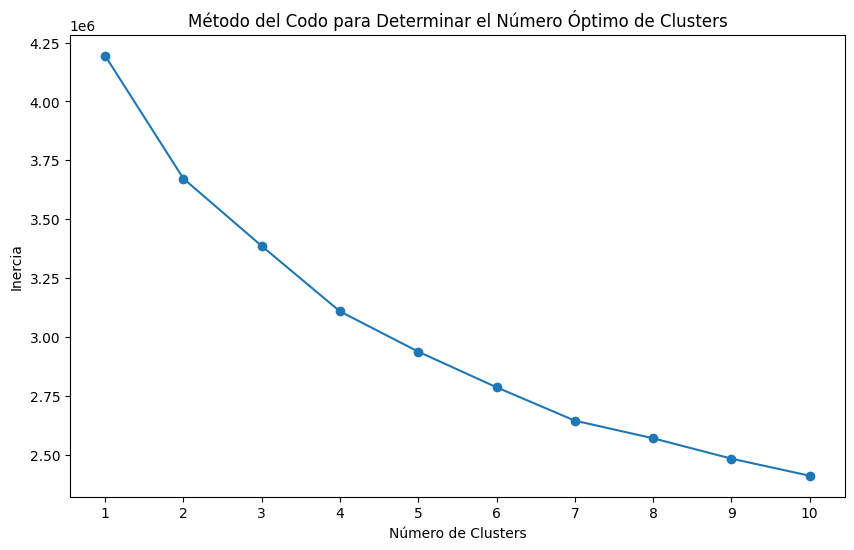

In [36]:
# Calcular la inercia para un rango de números de clusters
inercias = []
rangos_clusters = range(1, 11)
for k in rangos_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inercias.append(kmeans.inertia_)

# Graficar la inercia para ver el "codo"
plt.figure(figsize=(10, 6))
plt.plot(rangos_clusters, inercias, '-o')
plt.title('Método del Codo para Determinar el Número Óptimo de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.xticks(rangos_clusters)
plt.show()

In [37]:
# K-Means clustering con 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X)

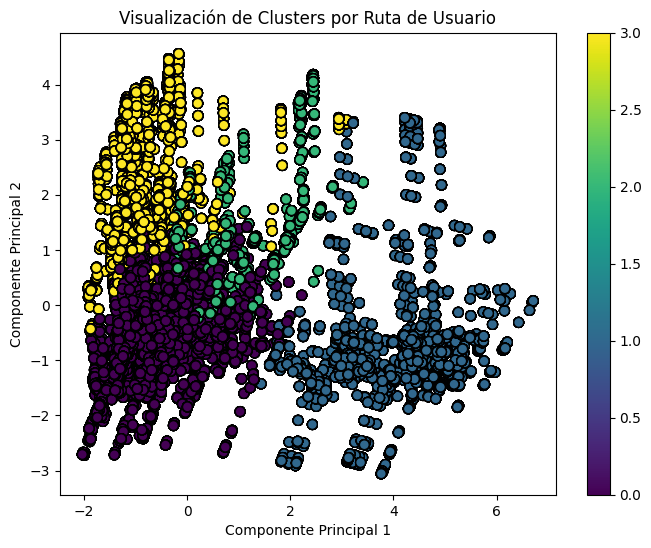

In [38]:
# Visualización de los clusters
# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.toarray())  # Convertir a un array denso si es necesario
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Visualización de Clusters por Ruta de Usuario')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar()
plt.show()

##ESTACIONES DE ENTRADA Y SALIDA

In [68]:
# Codificación one-hot de la columna 'Estación de entrada'
onehot_encoder = OneHotEncoder(sparse=False)
entry_stations_encoded = onehot_encoder.fit_transform(data[['Estación de entrada']])

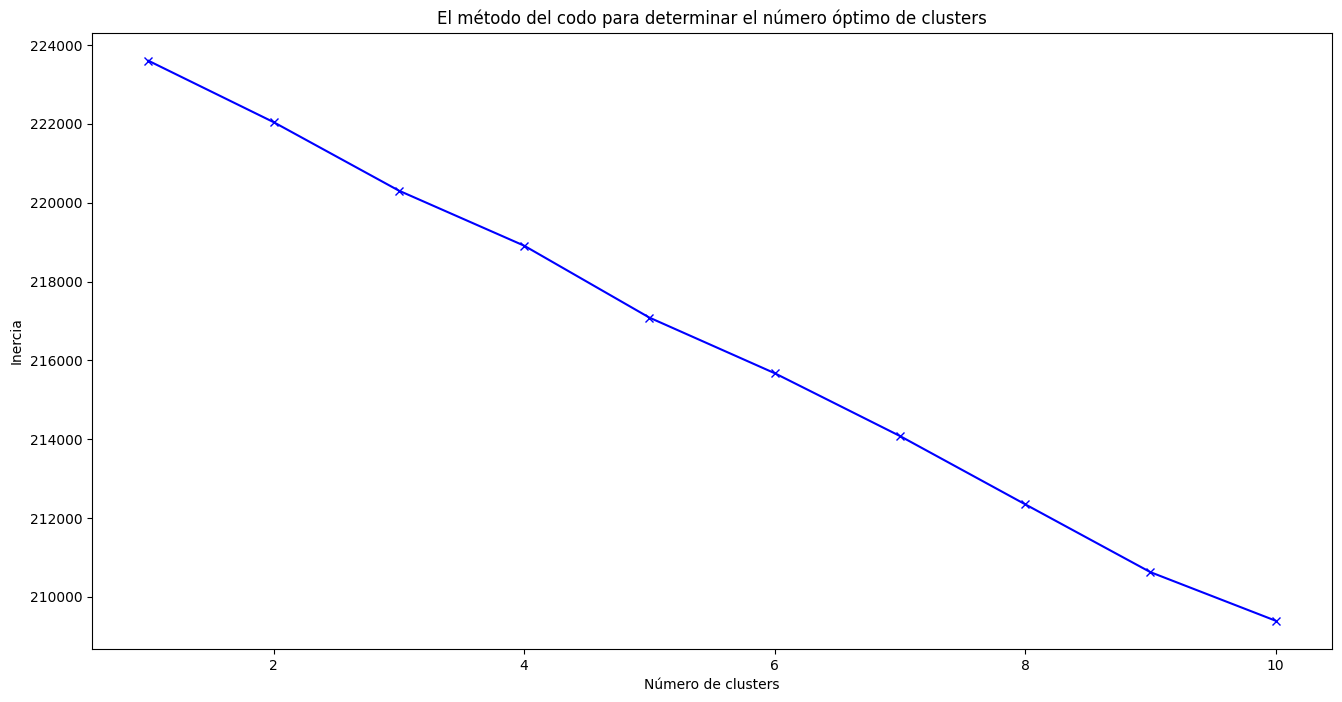

In [69]:
# Aplicando el método del codo para encontrar el número óptimo de clusters
inertia = []
K = range(1, 11)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(entry_stations_encoded)
    inertia.append(kmeanModel.inertia_)

# Graficar el método del codo
plt.figure(figsize=(16, 8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('El método del codo para determinar el número óptimo de clusters')
plt.show()

In [70]:
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(entry_stations_encoded)

# Agregar la etiqueta de cluster a tus datos originales
data['Cluster'] = clusters

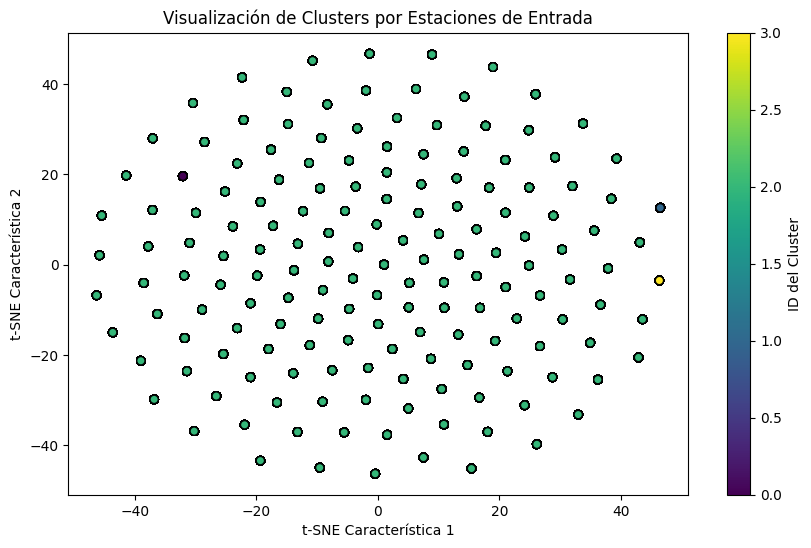

In [71]:
# Reducción de dimensionalidad con t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(entry_stations_encoded)

# Visualizar los clusters
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k')

plt.title('Visualización de Clusters por Estaciones de Entrada')
plt.xlabel('t-SNE Característica 1')
plt.ylabel('t-SNE Característica 2')
plt.colorbar(label='ID del Cluster')

plt.show()

OTRA FORMA DE HACERLO

In [72]:
# Convertir 'HoraDeEntrada' y 'HoraDeSalida' a minutos desde la medianoche
data['MinutosEntrada'] = pd.to_datetime(data['HoraDeEntrada'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data['HoraDeEntrada'], format='%H:%M:%S').dt.minute
data['MinutosSalida'] = pd.to_datetime(data['HoraDeSalida'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data['HoraDeSalida'], format='%H:%M:%S').dt.minute

In [73]:
# Codificación one-hot de las columnas 'Estación de entrada' y 'Estación de salida'
onehot_encoder = OneHotEncoder(sparse=False)
entry_stations_encoded = onehot_encoder.fit_transform(data[['Estación de entrada']])
exit_stations_encoded = onehot_encoder.fit_transform(data[['Estación de salida']])

# Combinar todas las características en un solo DataFrame
features = np.hstack((entry_stations_encoded, exit_stations_encoded, data[['MinutosEntrada', 'MinutosSalida']].values))

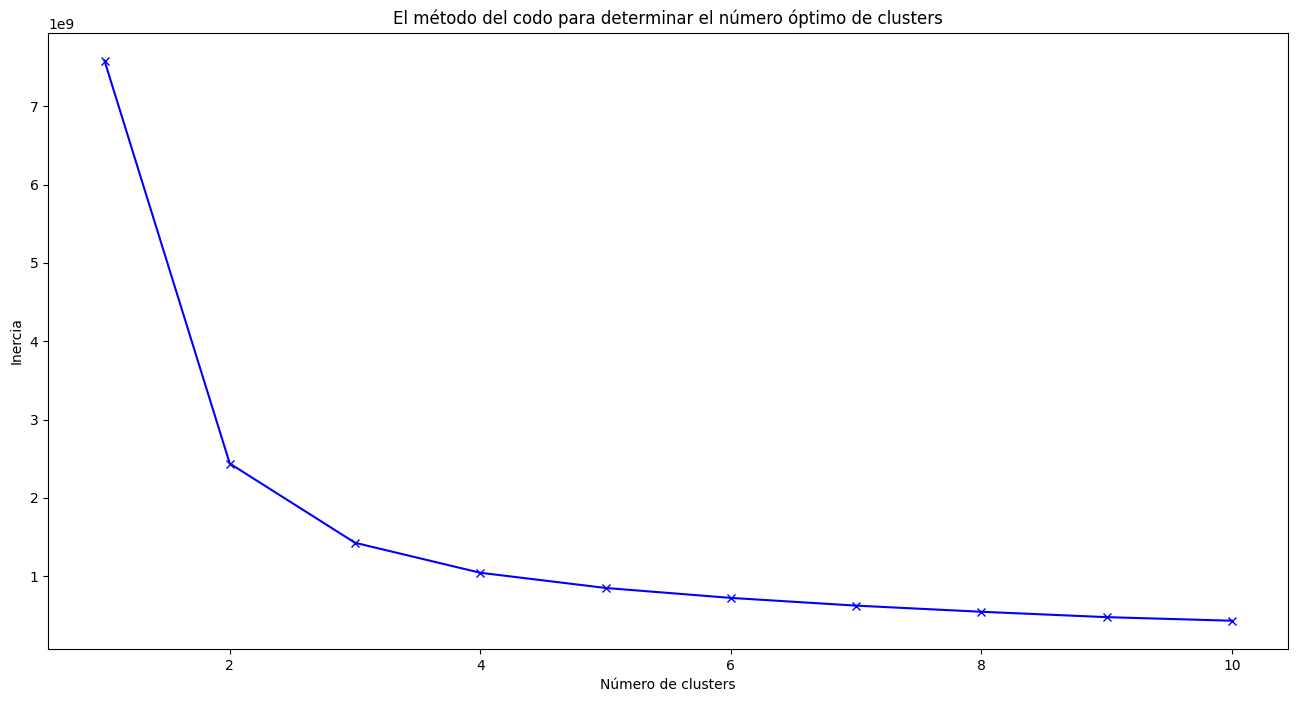

In [74]:
# Aplicar el método del codo para encontrar el número óptimo de clusters
inertia = []
K = range(1, 11)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(features)
    inertia.append(kmeanModel.inertia_)

# Graficar el método del codo
plt.figure(figsize=(16, 8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('El método del codo para determinar el número óptimo de clusters')
plt.show()

In [75]:
# Realizar la clusterización con el número óptimo de clusters
kmeans_optimo = KMeans(n_clusters=4)
clusters = kmeans_optimo.fit_predict(features)

# Aplicar PCA para reducir a 2 dimensiones para la visualización
pca = PCA(n_components=2)
features_reducidos = pca.fit_transform(features)

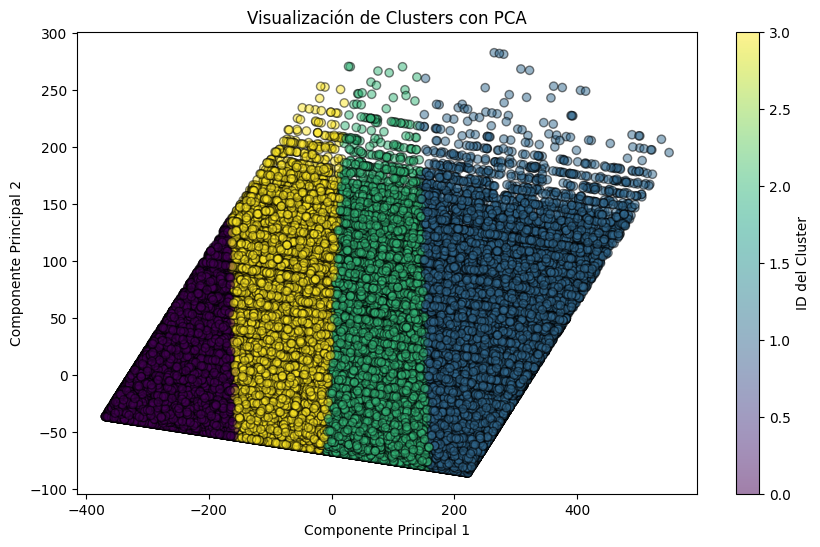

In [76]:
# Visualizar los clusters
plt.figure(figsize=(10, 6))
plt.scatter(features_reducidos[:, 0], features_reducidos[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k', alpha=0.5)
plt.title('Visualización de Clusters con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='ID del Cluster')
plt.show()